In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pyro
import pyro.distributions as dist
import scipy as sp
import scipy.stats
import time
import torch
import yaml
try:
    from yaml import CLoader as Loader
except ImportError:
    from yaml import Loader

In [2]:
# These scenes include uniformly randomly distributed nonpenetrating
# object arrangements
DATA_FILE = "data/20181127_uniform_feasible_1_box_1000/20181207_uniform_feasible_1_box_1000.yaml"
# These loaded scenes include squares on the left half of the scene, and
# long rectangles on the right half of the scene. All objects
# tend to lie along cardinal directions (theta = 0, pi/2, pi, ...)
#DATA_FILE = "data/20180709_sorted_grid_10000.yaml"

with open(DATA_FILE, "r") as f:
    environments = yaml.load(f, Loader=Loader)
    N_ENVIRONMENTS = len(environments.keys())
    print("Loaded %d environments from file %s" % (N_ENVIRONMENTS, DATA_FILE))
environments = [environments[key] for key in environments.keys()]

Loaded 1000 environments from file data/20181127_uniform_feasible_1_box_1000/20181207_uniform_feasible_1_box_1000.yaml


In [3]:
# Utilities
import generate_planar_scene_arrangements as psa_utils

def draw_rbt(ax, rbt, q):
    psa_utils.draw_board_state(ax, rbt, q)
    
    patch = patches.Rectangle([0., 0.], 1., 1., fill=True, color=[0., 1., 0.], 
                              linestyle='solid', linewidth=2, alpha=0.3)
    ax.add_patch(patch)
    
def draw_environment(environment, ax):
    rbt, q = psa_utils.build_rbt_from_summary(environment)
    draw_rbt(ax, rbt, q)

. Loss:  100.002983423
. . . . tensor([[2.2643e-02, 9.8818e-01, 8.1354e-01, 4.0253e-03, 1.9531e-03, 2.6952e-01,
         1.8242e-01, 4.5465e-01, 1.2102e+00, 7.1670e-03, 5.5769e-03, 1.7465e+00,
         8.9943e-01, 9.2312e-01, 8.4081e-01, 8.9213e-03, 5.5510e-03, 3.9019e-01,
         2.5376e-01, 3.1593e-01, 1.6142e+00, 1.2879e-02, 4.1663e-03, 4.7439e+00,
         3.9783e-01, 6.1001e-01, 8.9847e-01, 2.0121e-03, 2.1372e-03, 2.7058e+00,
         4.5746e-01, 6.7828e-01, 1.7713e+00, 8.6960e-03, 9.3333e-03, 5.7295e+00,
         8.2726e-01, 7.2424e-01, 8.3171e-01, 1.0036e-02, 1.3124e-02, 3.5241e+00,
         6.6827e-01, 4.7840e-01, 9.1665e-01, 5.9373e-03, 1.2073e-02, 5.4989e+00,
         4.9029e-01, 3.3108e-02, 8.3279e-01, 9.0304e-03, 2.8152e-03, 4.9978e-01,
         4.6925e-01, 4.6655e-01, 1.3875e+00, 1.9519e-03, 7.8394e-03, 2.0007e+00]],
       dtype=torch.float64, grad_fn=<TBackward>)


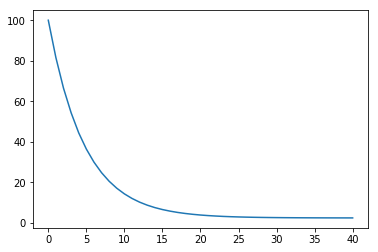

In [4]:
# Try out gradient descent through the projection operator
import differentiable_nlp as diff_nlp
from copy import deepcopy

device = torch.device('cpu')
env_i = environments[13]

rbt, qf = psa_utils.build_rbt_from_summary(env_i)
nq = rbt.get_num_positions()
#q = torch.tensor(qf.reshape(nq, 1), requires_grad=True)
np.random.seed(1)
q_start = np.random.random([nq, 1])
q = torch.tensor(q_start, requires_grad=True, dtype=torch.double)
q_target = torch.tensor(qf).view(nq, 1)

learning_rate = 0.05
constraints = [diff_nlp.object_origins_within_bounds_constraint_constructor_factory(
    np.array([0., 0., 0.5]), np.array([1., 1., 0.5]))]
losses = []
q_snapshots = []
q_pred_snapshots = []
for t in range(41):
    # Scheduling on the regularization in the derivative, which helps break off of
    # constraint surfaces during the first few iterations.
    q_pred = diff_nlp.projectToFeasibilityWithIKTorch.apply(q, rbt, constraints, 1/np.log(t+2))
    # Compute and print loss. Loss is a Tensor of shape (), and loss.item()
    # is a Python number giving its value.
    loss = (q_pred - q_target).pow(2).sum()
    losses.append(loss.cpu().detach().item())
    q_snapshots.append(q.cpu().detach().numpy().copy())
    q_pred_snapshots.append(q_pred.cpu().detach().numpy().copy())
    loss.backward()
    with torch.no_grad():
        q -= learning_rate * q.grad
        # Manually zero the gradients after running the backward pass
        q.grad.zero_()
    if t % 10 == 0:
        print ".",
    if t % 100 == 0:
        print "Loss: ", loss.cpu().detach().item()

print torch.t(q)
plt.figure()
plt.plot(losses)

In [5]:
from underactuated import PlanarRigidBodyVisualizer
from matplotlib import animation, rc
from IPython.display import HTML

Tview = np.array([[1., 0., 0., 0.],
                  [0., 1., 0., 0.],
                  [0., 0., 0., 0.],
                  [0., 0., 0., 1.]])

fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('equal')
ax.axis('off')
viz = PlanarRigidBodyVisualizer(
    rbt, Tview, xlim=[-0.25, 1.25], ylim=[-0.25, 1.25], ax=ax)
def animate_update(i):
    viz.draw(q_snapshots[i])
ani = animation.FuncAnimation(fig,
                              animate_update,
                              len(q_snapshots),
                              interval=2000/len(q_snapshots),
                              repeat=True)
plt.close(fig)
HTML(ani.to_html5_video()) # This needs to be the last line for the video to display

/home/gizatt/miniconda2/envs/py27/lib/python2.7/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [6]:
from underactuated import PlanarRigidBodyVisualizer
from matplotlib import animation, rc
from IPython.display import HTML

Tview = np.array([[1., 0., 0., 0.],
                  [0., 1., 0., 0.],
                  [0., 0., 0., 0.],
                  [0., 0., 0., 1.]])

fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('equal')
ax.axis('off')
viz = PlanarRigidBodyVisualizer(
    rbt, Tview, xlim=[-0.25, 1.25], ylim=[-0.25, 1.25], ax=ax)
def animate_update(i):
    viz.draw(q_pred_snapshots[i])
ani = animation.FuncAnimation(fig,
                              animate_update,
                              len(q_pred_snapshots),
                              interval=2000/len(q_pred_snapshots),
                              repeat=True)
plt.close(fig)
HTML(ani.to_html5_video()) # This needs to be the last line for the video to display

In [7]:
# These scenes include uniformly randomly distributed nonpenetrating
# object arrangements WITH EXACTLY 2 OBJECTS
DATA_FILE = "data/20181127_uniform_feasible_1_box_1000/20181214_uniform_feasible_2_box_1000.yaml"

with open(DATA_FILE, "r") as f:
    environments = yaml.load(f, Loader=Loader)
    N_ENVIRONMENTS = len(environments.keys())
    print("Loaded %d environments from file %s" % (N_ENVIRONMENTS, DATA_FILE))
environments = [environments[key] for key in environments.keys()]

Loaded 1000 environments from file data/20181127_uniform_feasible_1_box_1000/20181214_uniform_feasible_2_box_1000.yaml


Selection of environments from prior / generative model


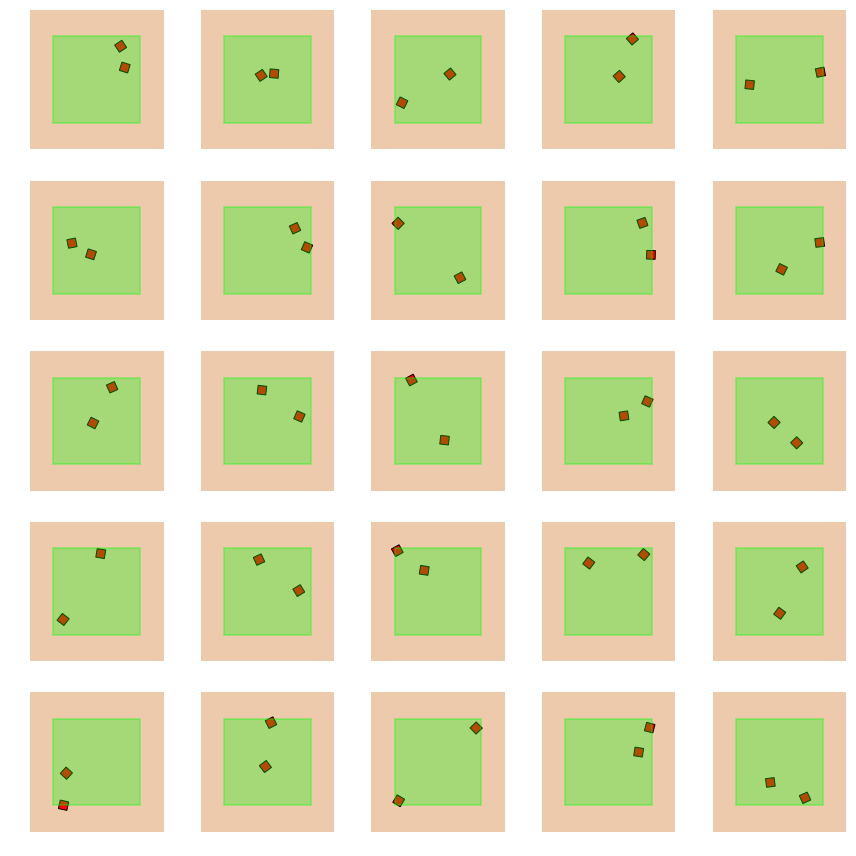

In [8]:
plt.figure().set_size_inches(12, 12)
print "Selection of environments from prior / generative model"
N = 5

for i in range(N):
    for j in range(N):
        plt.subplot(N, N, i*N+j+1)
        draw_environment(environments[i*N+j+1], plt.gca())
        plt.grid(True)
plt.tight_layout()

In [9]:
# Test some functionality of the custom distribution type
dummy_env = deepcopy(environments[0])
dummy_env["n_objects"] = 1
one_box_rbt, _ = psa_utils.build_rbt_from_summary(dummy_env)
ik_constraints = [diff_nlp.object_origins_within_bounds_constraint_constructor_factory(
    np.array([0., 0., 0.5]), np.array([1., 1., 0.5]))]
q0 = torch.tensor([[-0.1 , 0., 0., 0., 0., 0]], requires_grad=True)
distrib = diff_nlp.ProjectToFeasibilityWithIKAsDistribution(
    one_box_rbt, q0, ik_constraints, 0.1, 0.01)
qf = distrib.sample()
qother = torch.Tensor([[0.1 , 0., 0., 0., 0., 0]])
print "q0: ", q0, distrib.log_prob(q0)
print "qf: ", qf, distrib.log_prob(qf)
print "qother: ", qother, distrib.log_prob(qother)
if distrib.log_prob(qother).item() <= distrib.log_prob(q0).item():
    raise NotImplementedError("I must not have finished this yet")
# Eventually qother should be < qf, but > q0, even though it's the same
# distance from the constraint plane at x>0

q0:  tensor([[-0.1000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],
       requires_grad=True) tensor([7.8019], grad_fn=<SumBackward2>)
qf:  tensor([[0., 0., 0., 0., 0., 0.]], requires_grad=True) tensor([8.3019], grad_fn=<SumBackward2>)
qother:  tensor([[0.1000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]) tensor([7.8019], grad_fn=<SumBackward2>)


NotImplementedError: I must not have finished this yet

In [267]:
# Ok, now deploy it in an inference context
from collections import namedtuple
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro import poutine
from pyro.infer import config_enumerate
import differentiable_nlp as diff_nlp
import generate_planar_scene_arrangements as psa_utils

pyro.enable_validation(True)

class DataWrapperForObs:
    # Convenience wrapper on data:
    # If data's batch dimension is length-0,
    # we must be running the model in generative mode,
    # so any slicing returns None.
    # Otherwise, pass through slicing to the real data.
    def __init__(self, data):
        self.data = data
    def __getitem__(self, key):
        if self.data.shape[0] > 0:
            return self.data[key]
        else:
            return None
   
# Cobbling together some RBTs ahead of time for convenience
# 2-obj env
print environments[0]
two_box_rbt, _ = psa_utils.build_rbt_from_summary(environments[0])
# 1-obj env
dummy_env = deepcopy(environments[0])
dummy_env["n_objects"] = 1
one_box_rbt, _ = psa_utils.build_rbt_from_summary(dummy_env)
assert(two_box_rbt.get_num_positions() == 12)
assert(one_box_rbt.get_num_positions() == 6)
rbts = [one_box_rbt, two_box_rbt]
ik_constraint = [diff_nlp.object_at_specified_pose_constraint_constructor_factory(
    0, np.array([0., 0., 0.5, 0., 0., 0.]), np.array([1., 1., 0.5, 0., 0., 2*np.pi]))]
ik_constraint_2 = ik_constraint + [
    diff_nlp.object_at_specified_pose_constraint_constructor_factory(
        1, np.array([0., 0., 0.5, 0., 0., 0.]), np.array([1., 1., 0.5, 0., 0., 2*np.pi]))]
ik_constraints = [ik_constraint, ik_constraint_2]

def expand_partial_pose_to_full_pose(n_boxes, last_poses, this_pose):
    full_poses = torch.zeros(this_pose.shape[0], n_boxes*6,
                             requires_grad=False,
                             dtype=this_pose.dtype)
    for k in range(n_boxes):
        if (k == n_boxes - 1):
            full_poses[:, k*6 + 0] = this_pose[:, 0]
            full_poses[:, k*6 + 1] = this_pose[:, 1]
            full_poses[:, k*6 + 5] = this_pose[:, 2]
        else:
            full_poses[:, k*6 + 0] = last_poses[:, k*3+0]
            full_poses[:, k*6 + 1] = last_poses[:, k*3+1]
            full_poses[:, k*6 + 5] = last_poses[:, k*3+2]
    return full_poses

def collapse_full_pose_to_partial_pose(n_boxes, pose):
    partial_pose = torch.zeros(pose.shape[0], n_boxes*3, requires_grad=False,
                       dtype=pose.dtype)
    for k in range(n_boxes):
        partial_pose[:, k*3+0] = pose[:, k*6 + 0]
        partial_pose[:, k*3+1] = pose[:, k*6 + 1]
        partial_pose[:, k*3+2] = pose[:, k*6 + 5]
    return partial_pose

# Sample an exactly 2-object environment
# "data" is either None (run in generative mode),
# or is n_batches x 6 (environment pose vectors)
N_OBJECTS = 2
def model(data = torch.Tensor(0, 12), use_projection=True, subsample_size=None,
          noisy_projection=False):
    if data.shape[1] != 12:
        raise ValueError("Expected data to have n_batches x 12 shape.")
    
    # Object placement distribution is shared across objects
    # (maybe switch this to Normal-inverse-Wishart_distribution, if supported?)
    box_mean = pyro.sample('box_mean', dist.Normal(0.5, 0.1).expand([3]).to_event(1))
    box_var = pyro.sample('box_var', dist.LogNormal(-2.5, 1.0).expand([3]).to_event(1))
    box_dist = dist.MultivariateNormal(box_mean, torch.diag(box_var))
    
    data_batch_size = max(1, data.shape[0])
    # Who knows why, but pyro's subsampling wasn't being random during SVI.
    # Someone somewhere might be resetting internal RNG state.
    # Here I force RNG from the torch RNG.
    indices = torch.randperm(data_batch_size)[0:(subsample_size or data_batch_size)]
    if data.shape[0] > 0:
        data_subsample = data[indices, :]
    else:
        data_subsample = data
    with pyro.plate('data', subsample_size or data_batch_size):
        generated_data = torch.zeros(subsample_size or data_batch_size, 3*N_OBJECTS)
        
        data_obs = DataWrapperForObs(data_subsample[:, :])
        
        last_scene_config = None
        for k in range(N_OBJECTS):
            if use_projection:
                new_pose = pyro.sample("scene_%d_pre_pose" % k, box_dist)
                projection_dist = diff_nlp.ProjectToFeasibilityWithIKAsDistribution(
                    rbts[k], expand_partial_pose_to_full_pose(k+1, last_scene_config, new_pose),
                    ik_constraints[k], 0.05, 0.01, noisy_projection=noisy_projection)
                if k == N_OBJECTS - 1:
                    projected_pose = pyro.sample("scene_%d_pose" % k, projection_dist, obs=data_obs[:, :])
                    generated_data[:, :] = collapse_full_pose_to_partial_pose(N_OBJECTS, projected_pose)[:, :]
                else:
                    projected_pose = pyro.sample("scene_%d_pose" % k, projection_dist, obs=data_obs[:, :6*k+6])
                last_scene_config = projected_pose
            else:
                projected_pose = pyro.sample("box_%d_pose" % k, box_dist, obs=data_obs[:, [k*6, k*6+1, k*6+5]])
                generated_data[:, (k*3):(k*3+3)] = projected_pose[:, :]
    
    return generated_data

for k in range(100):
    model()

{'obj_0000': {'pose': [0.8509978117586199, 0.489187803635579, 1.6982042672090187], 'class': 'small_box'}, 'obj_0001': {'pose': [0.6158417183505649, 0.8990436884493441, 2.966257382400049], 'class': 'small_box'}, 'n_objects': 2}


In [268]:
def vectorize_environments(envs):
    # Vectorization into a 
    # poses (order x y 0 0 0 theta) per object
    n_environments = len(envs)
    poses = torch.Tensor(n_environments, 2*6)
    poses[:, :] = 0.
    for i, env in enumerate(envs):
        for k in range(2):
            obj = env["obj_%04d" % k]
            poses[i, (k*6):(k*6+6)][[0, 1, 5]] = torch.Tensor(obj["pose"])
    return poses
    
def devectorize_environments(data):
    envs = []
    for i in range(data.shape[0]):
        env = {}
        n_objects = 0
        for k in range(2):
            obj = {
                "pose": data[i, (k*3):(k*3+3)].cpu().detach().numpy(),
                "class": "small_box"
            }
            env["obj_%04d" % k] = obj
        env["n_objects"] = 2
        envs.append(env)
    return envs

# Make sure we can run model + condition on this dataset
model(vectorize_environments(environments), subsample_size=20, use_projection=True)

tensor([[0.1745, 0.9167, 2.4313, 0.7916, 0.5297, 2.8363],
        [0.1651, 0.8786, 4.7830, 0.4778, 0.2168, 5.6509],
        [0.3958, 0.0759, 4.6078, 0.1099, 0.8222, 5.0225],
        [0.0702, 0.7420, 2.6390, 0.2908, 0.9199, 5.3961],
        [0.8762, 0.6805, 4.0373, 0.5142, 0.4494, 2.1128],
        [0.6371, 0.5634, 3.8379, 0.0844, 0.2329, 4.2553],
        [0.7440, 0.7315, 0.0740, 0.0422, 0.4618, 0.0518],
        [0.6541, 0.7059, 5.9572, 0.9734, 0.5657, 3.7798],
        [0.7456, 0.5227, 4.2073, 0.1429, 0.7365, 5.5796],
        [0.9601, 0.5502, 2.8764, 0.2260, 0.6990, 0.6285],
        [0.6807, 0.8883, 2.6278, 0.5848, 0.2703, 4.0337],
        [0.7074, 0.2409, 5.9182, 0.9877, 0.1261, 1.3374],
        [0.0137, 0.1766, 0.6526, 0.3760, 0.6335, 2.0464],
        [0.9439, 0.5343, 1.3699, 0.7874, 0.8347, 0.1617],
        [0.3064, 0.8639, 0.9516, 0.6597, 0.4273, 5.0834],
        [0.3458, 0.1929, 0.8851, 0.1915, 0.6458, 6.2547],
        [0.7107, 0.1449, 4.3135, 0.4399, 0.2481, 4.8704],
        [0.130

In [269]:
# Some statistics over what we expect of environment mean + var
data = vectorize_environments(environments).detach().numpy()
print "Mean postures: ", np.mean(data, axis=0)
print "std postures: ", np.std(data, axis=0)
print "var of postures: ", np.square(np.std(data, axis=0))
print "log-var postures: ", np.log(np.square(np.std(data, axis=0)))

Mean postures:  [0.50985354 0.50948626 0.         0.         0.         3.2155168
 0.4947123  0.49772808 0.         0.         0.         3.161191  ]
std postures:  [0.2870375  0.28578308 0.         0.         0.         1.8388928
 0.29076204 0.29229698 0.         0.         0.         1.8325927 ]
var of postures:  [0.08239052 0.08167197 0.         0.         0.         3.3815267
 0.08454257 0.08543752 0.         0.         0.         3.358396  ]
log-var postures:  [-2.496285  -2.5050445       -inf       -inf       -inf  1.2183273
 -2.4705002 -2.45997         -inf       -inf       -inf  1.2114635]


/home/gizatt/miniconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


Selection of environments from prior / generative model


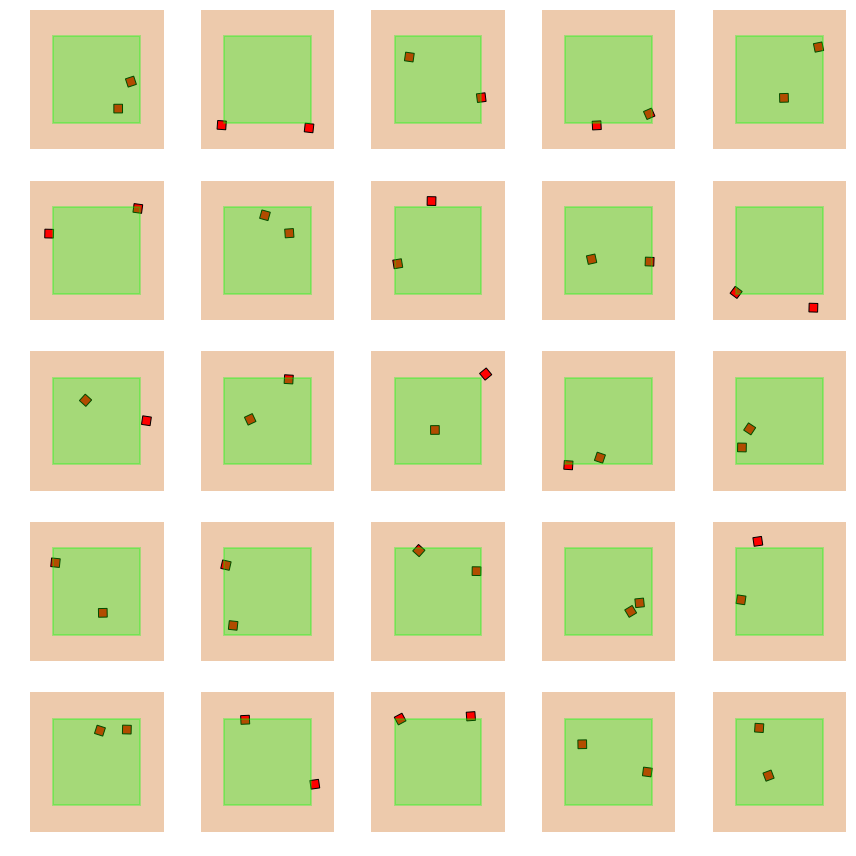

In [270]:
plt.figure().set_size_inches(12, 12)
print "Selection of environments from prior / generative model"
N = 5

for i in range(N):
    for j in range(N):
        plt.subplot(N, N, i*N+j+1)
        draw_environment(devectorize_environments(
            poutine.condition(model, data={"box_var": torch.Tensor([0.25, 0.25, 3.1415]),
                                           "box_mean": torch.Tensor([0.5, 0.5, 3.1415])})())[0], plt.gca())
        plt.grid(True)
plt.tight_layout()

Notes on SVI performance:

Using noisy projection didn't seem to have an important impact on SVI.

In [271]:
# Rig for SVI.
from collections import defaultdict
from torch.distributions import constraints
from pyro.infer import Trace_ELBO, SVI
from pyro.optim import Adam
from pyro.contrib.autoguide import AutoDelta, AutoDiagonalNormal, AutoMultivariateNormal

pyro.enable_validation(True)

interesting_params = ["box_mean", "box_var"]
def select_interesting(guide):
    all_params = global_guide.median()
    return dict((p, all_params[p]) for p in interesting_params)

pyro.clear_param_store()
global_guide = AutoDiagonalNormal(
    poutine.block(model, hide=["obs"]))
    #poutine.block(model, expose=interesting_params))
optim = pyro.optim.Adam({'lr': 0.2, 'betas': [0.8, 0.99]})
elbo = Trace_ELBO(max_plate_nesting=1)
svi = SVI(model, global_guide, optim, loss=elbo)
losses = []
data = vectorize_environments(environments)

snapshots = {}
for i in range(501):
    loss = svi.step(data, subsample_size=50, use_projection=True)
    losses.append(loss)
    snapshot_median = global_guide.median()
    for p in snapshot_median.keys():
        if p not in snapshots.keys():
            snapshots[p] = []
        snapshots[p].append(snapshot_median[p].cpu().detach().numpy().copy())
    if (i % 10 == 0):
        print ".",
    if (i % 50 == 0):
        print "\n"
        print select_interesting(global_guide)
print "Done"


. 

{'box_var': tensor([0.8187, 1.2214, 0.8187], grad_fn=<AddBackward0>), 'box_mean': tensor([-0.2000, -0.2000,  0.2000], grad_fn=<ViewBackward>)}
. . . . . 

{'box_var': tensor([0.5905, 0.6754, 5.6110], grad_fn=<AddBackward0>), 'box_mean': tensor([0.5469, 0.5073, 0.9789], grad_fn=<ViewBackward>)}
. . . . . 

{'box_var': tensor([0.2540, 0.3347, 4.9633], grad_fn=<AddBackward0>), 'box_mean': tensor([0.5932, 0.4813, 1.0085], grad_fn=<ViewBackward>)}
. . . . . 

{'box_var': tensor([0.1305, 0.1817, 5.3170], grad_fn=<AddBackward0>), 'box_mean': tensor([0.5319, 0.5631, 0.9938], grad_fn=<ViewBackward>)}
. . . . . 

{'box_var': tensor([0.1233, 0.0834, 4.4554], grad_fn=<AddBackward0>), 'box_mean': tensor([0.5391, 0.4987, 0.9457], grad_fn=<ViewBackward>)}
. . . . . 

{'box_var': tensor([0.0405, 0.0420, 4.4589], grad_fn=<AddBackward0>), 'box_mean': tensor([0.5289, 0.5044, 0.7771], grad_fn=<ViewBackward>)}
. . . . . 

{'box_var': tensor([0.0347, 0.0403, 4.0054], grad_fn=<AddBackward0>), 'box_mean':

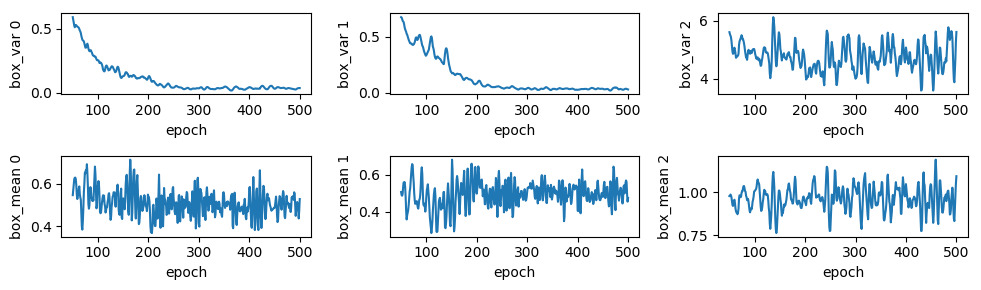

In [272]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
keys = ["box_var", "box_mean"]
n_plots = len(keys)
for i, key in enumerate(keys):
    data_across_epochs = np.vstack(snapshots[key])
    for k in range(3):
        plt.subplot(n_plots, 3, i*3+k+1)
        start_epoch = 50
        plt.plot(np.arange(start_epoch, data_across_epochs.shape[0]), data_across_epochs[start_epoch:, k])
        plt.xlabel('epoch')
        plt.ylabel(key + " %d" % k)
plt.tight_layout()

{'box_var': tensor([0.0370, 0.0293, 5.6178], grad_fn=<AddBackward0>), 'box_mean': tensor([0.5287, 0.4754, 1.0951], grad_fn=<ViewBackward>), 'scene_1_pre_pose': tensor([[ 0.6715,  0.3182,  3.4298],
        [ 0.3315,  0.6381,  3.7969],
        [ 0.3001,  0.5958,  2.9165],
        [ 0.4154,  0.4844,  3.2842],
        [ 0.9171,  0.3948,  3.3992],
        [ 0.7480,  0.3438,  3.5844],
        [ 0.3493,  0.4476,  2.9741],
        [ 0.4602,  0.4225,  2.5988],
        [ 0.4346,  0.4560,  3.0278],
        [ 0.4251,  0.7346,  3.3707],
        [ 0.8084,  0.2932,  3.5174],
        [ 0.4340,  0.3557,  3.1007],
        [ 0.4457,  0.7169,  2.8329],
        [ 0.6558,  0.4671,  3.1364],
        [ 0.5496,  0.7530,  3.8230],
        [ 0.5178,  0.9674,  2.8443],
        [ 0.5390,  0.8024,  2.8914],
        [ 0.6200,  0.2048,  3.0650],
        [ 0.4959,  0.5786,  3.0012],
        [ 0.4282,  0.7235,  2.8960],
        [ 0.3467,  0.2937,  3.4762],
        [ 0.6977,  0.5563,  2.9863],
        [ 0.5237,  0.3534,

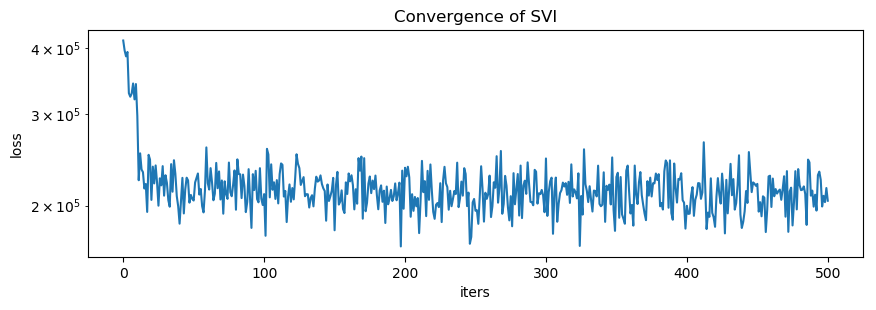

In [273]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');
print global_guide.median()

Selection of environments from prior / generative model


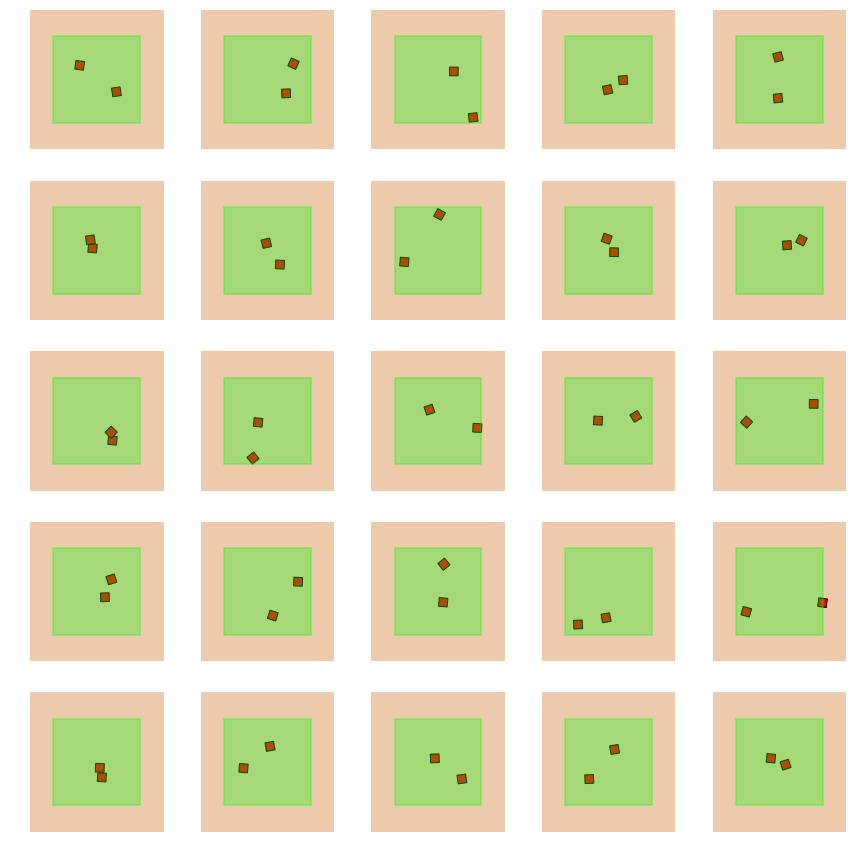

In [274]:
plt.figure().set_size_inches(12, 12)
print "Selection of environments from prior / generative model"
N = 5

for i in range(N):
    for j in range(N):
        plt.subplot(N, N, i*N+j+1)
        sample = poutine.condition(model, data=select_interesting(global_guide))()
        draw_environment(devectorize_environments(sample)[0], plt.gca())
        plt.grid(True)
plt.tight_layout()

In [286]:
# MCMC?

from pyro.infer.mcmc import HMC, MCMC, NUTS
from pyro.infer import EmpiricalMarginal

hmc_kernel = NUTS(model)
mcmc_run = MCMC(hmc_kernel, num_samples=400, warmup_steps=100).run(data, subsample_size=10, use_projection=True, noisy_projection=True)

SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdXYXJtdXAnLCBtYXg9NTAwLCBzdHlsZT1Qcm9ncmVzc1N0eWxlKGRlc2NyaXB0aW9uX3dpZHRoPXUnaW7igKY=


Box mean, empirical:  tensor([0.4289, 0.5018, 0.5177])  +/-  tensor([6.0041e-13, 1.7195e-12, 4.3521e-12])
Box var, empirical:  tensor([0.0305, 0.0596, 0.1330])  +/-  tensor([7.3413e-15, 3.7526e-14, 1.6187e-13])


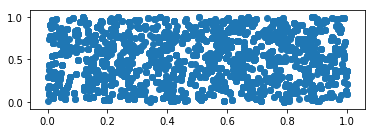

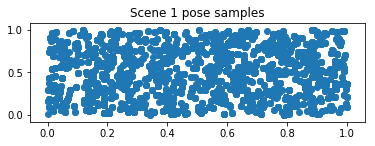

<Figure size 432x288 with 0 Axes>

In [315]:
# do some analysis of that when it comes out
posterior_box_mean = EmpiricalMarginal(mcmc_run, 'box_mean')
print "Box mean, empirical: ", posterior_box_mean.mean, " +/- ", posterior_box_mean.variance
posterior_box_var = EmpiricalMarginal(mcmc_run, 'box_var')
print "Box var, empirical: ", posterior_box_var.mean, " +/- ", posterior_box_var.variance

def plot_empirical_marginal(ax, empirical_marginal, subind_x, subind_y):
    datapoints = empirical_marginal._samples.detach().numpy()
    plt.scatter(datapoints[:, :, subind_x].flatten(), datapoints[:, :, subind_y].flatten())
    plt.show()

plt.figure()
plt.subplot(2, 1, 1)
plot_empirical_marginal(plt.gca(), EmpiricalMarginal(mcmc_run, 'scene_0_pose'), 0, 1)
plt.title("Scene 0 pose samples")
plt.subplot(2, 1, 2)
plt.title("Scene 1 pose samples")
plot_empirical_marginal(plt.gca(), EmpiricalMarginal(mcmc_run, 'scene_1_pose'), 0, 1)
plt.tight_layout();